<a href="https://colab.research.google.com/github/christophersw/Data660-Assignment5/blob/main/Webster_Unit_5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Assignment - Ensemble Models


*by* Christopher Webster

*for* Unit 5 Assignment, DATA 660 9040

Professor Steve Knode

February 10, 2026

## Environment Setup

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings('ignore')


## Data Loading and Preprocessing
- Loads the Adult dataset from a *.csv file
- Review column names
- Check for missing values
- Ensure that the target variable **churn** is encoded as a bool, and has only bool values
- Drop **phone number** as this is an identifier
- Converts categorical features to numeric using one-hot encoding


* * * * Loading data * * * * 

Data loaded: 
(3333, 21)

* * * * Column Names * * * * 

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

* * * * Check for Missing Values * * * * 

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes      

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,False,False,False,False,False,False,True,False,False,True
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,False,False,False,False,False,False,True,False,False,True
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,False,False,False,False,False,False,True,False,False,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,False,False,False,False,False,False,False,False,True,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,False,False,False,False,False,False,True,False,True,False



* * * * Check for Duplicates * * * * 

No duplicate rows found.

* * * * Check for Outliers * * * * 


* * * * Box Plot of Outliers * * * * 



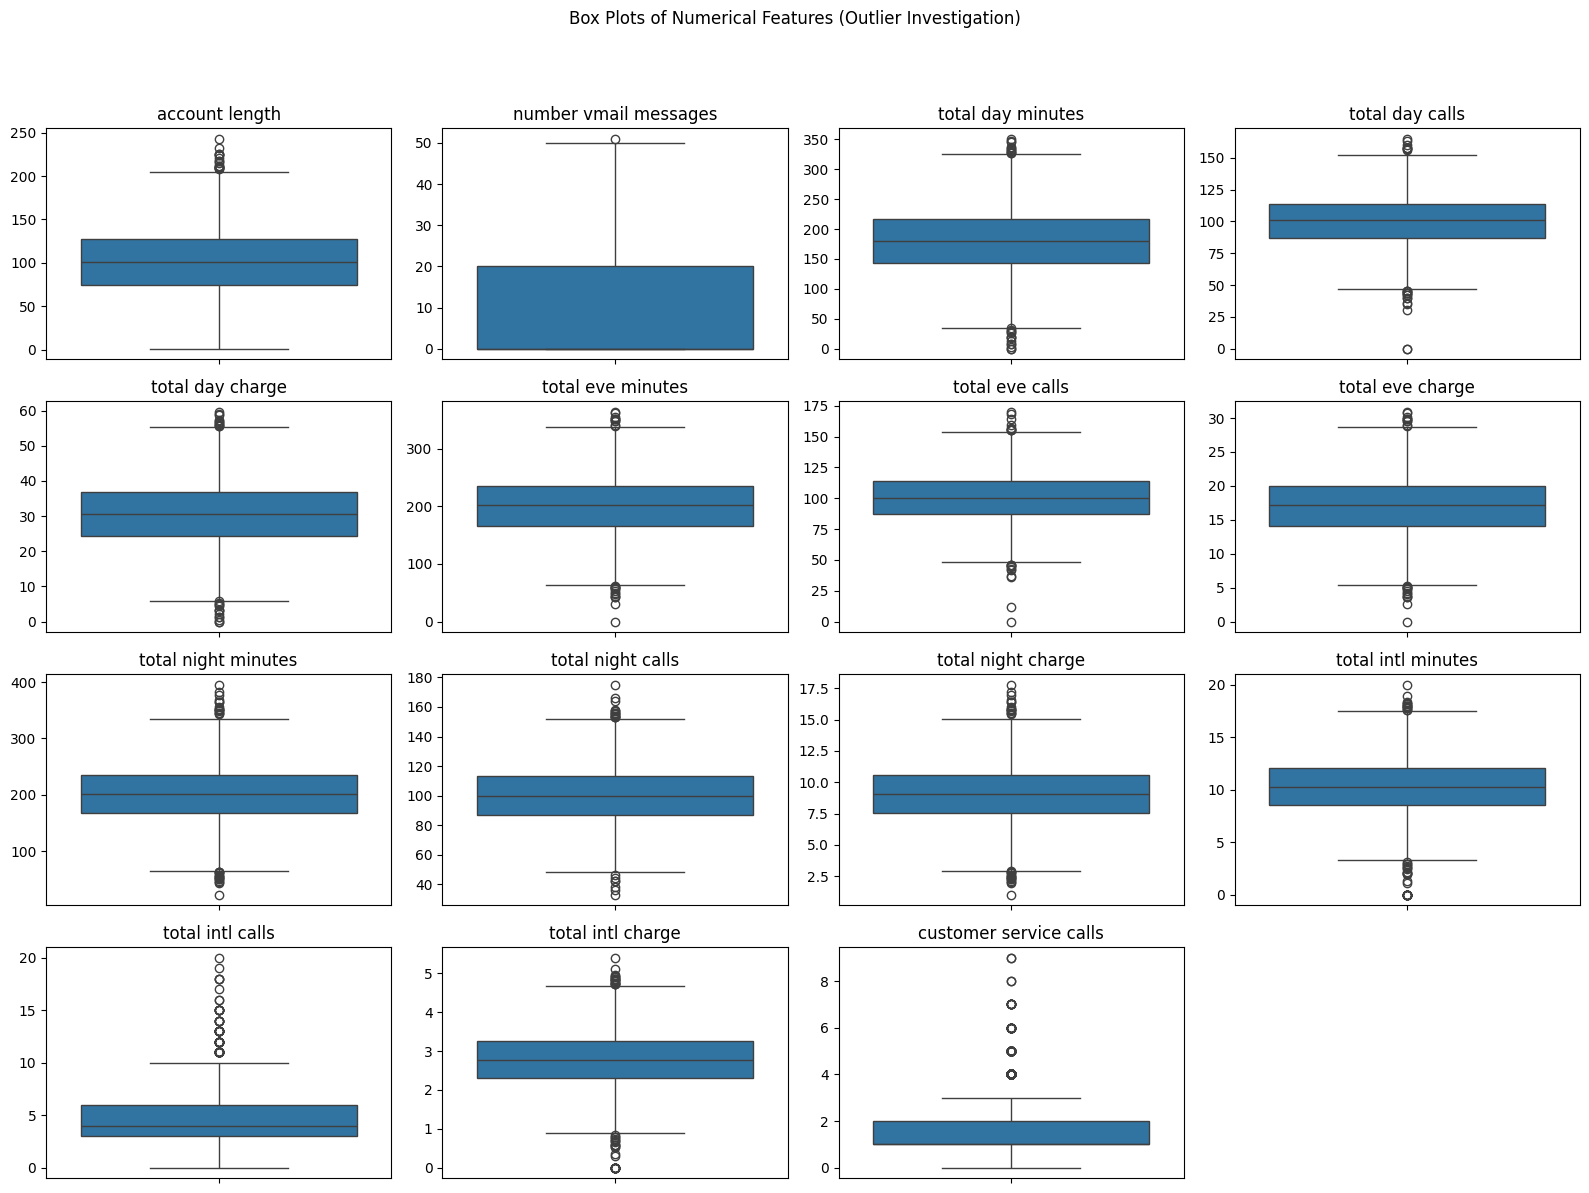

In [ ]:
# Load data
print ("\n* * * * Loading data * * * * \n")
data = pd.read_csv('/content/Cell Phone Company Churn data.csv')
print('Data loaded: ')
print(data.shape)

# Look at column names
print ("\n* * * * Column Names * * * * \n")
print(data.columns)

# Look for missing values
print ("\n* * * * Check for Missing Values * * * * \n")
print(data.isnull().sum())

# Check that target variable is encoded as T/F
print ("\n* * * * Check Target Variable Encoding * * * * \n")
print("Unique values in 'churn' column:")
print(data['churn'].unique())
print("\nData type of 'churn' column:")
print(data['churn'].dtype)


print ("\n* * * * One-hot Encoding * * * * \n")

# Convert 'area code' to object type to ensure it's treated as categorical
data['area code'] = data['area code'].astype(str)

# Identify categorical columns to one-hot encode, excluding 'phone number' and 'churn'
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' and col not in ['phone number', 'churn']]

# Apply one-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Drop the 'phone number' column as it's an identifier and not useful for modeling
data_encoded = data_encoded.drop(columns=['phone number'])

print("Shape of data after one-hot encoding:", data_encoded.shape)
print("Columns after one-hot encoding:", data_encoded.columns.tolist())
display(data_encoded.head())

# Check for duplicate rows
print ("\n* * * * Check for Duplicates * * * * \n")
duplicate_rows = data_encoded[data_encoded.duplicated()]

if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} duplicate rows:")
    display(duplicate_rows)
else:
    print("No duplicate rows found.")

### Identifying outliers
- generate box plots to identify outliers using IQR


* * * * Check for Outliers * * * * 

Number of rows with outliers: 529

* * * * Box Plot of Outliers * * * * 



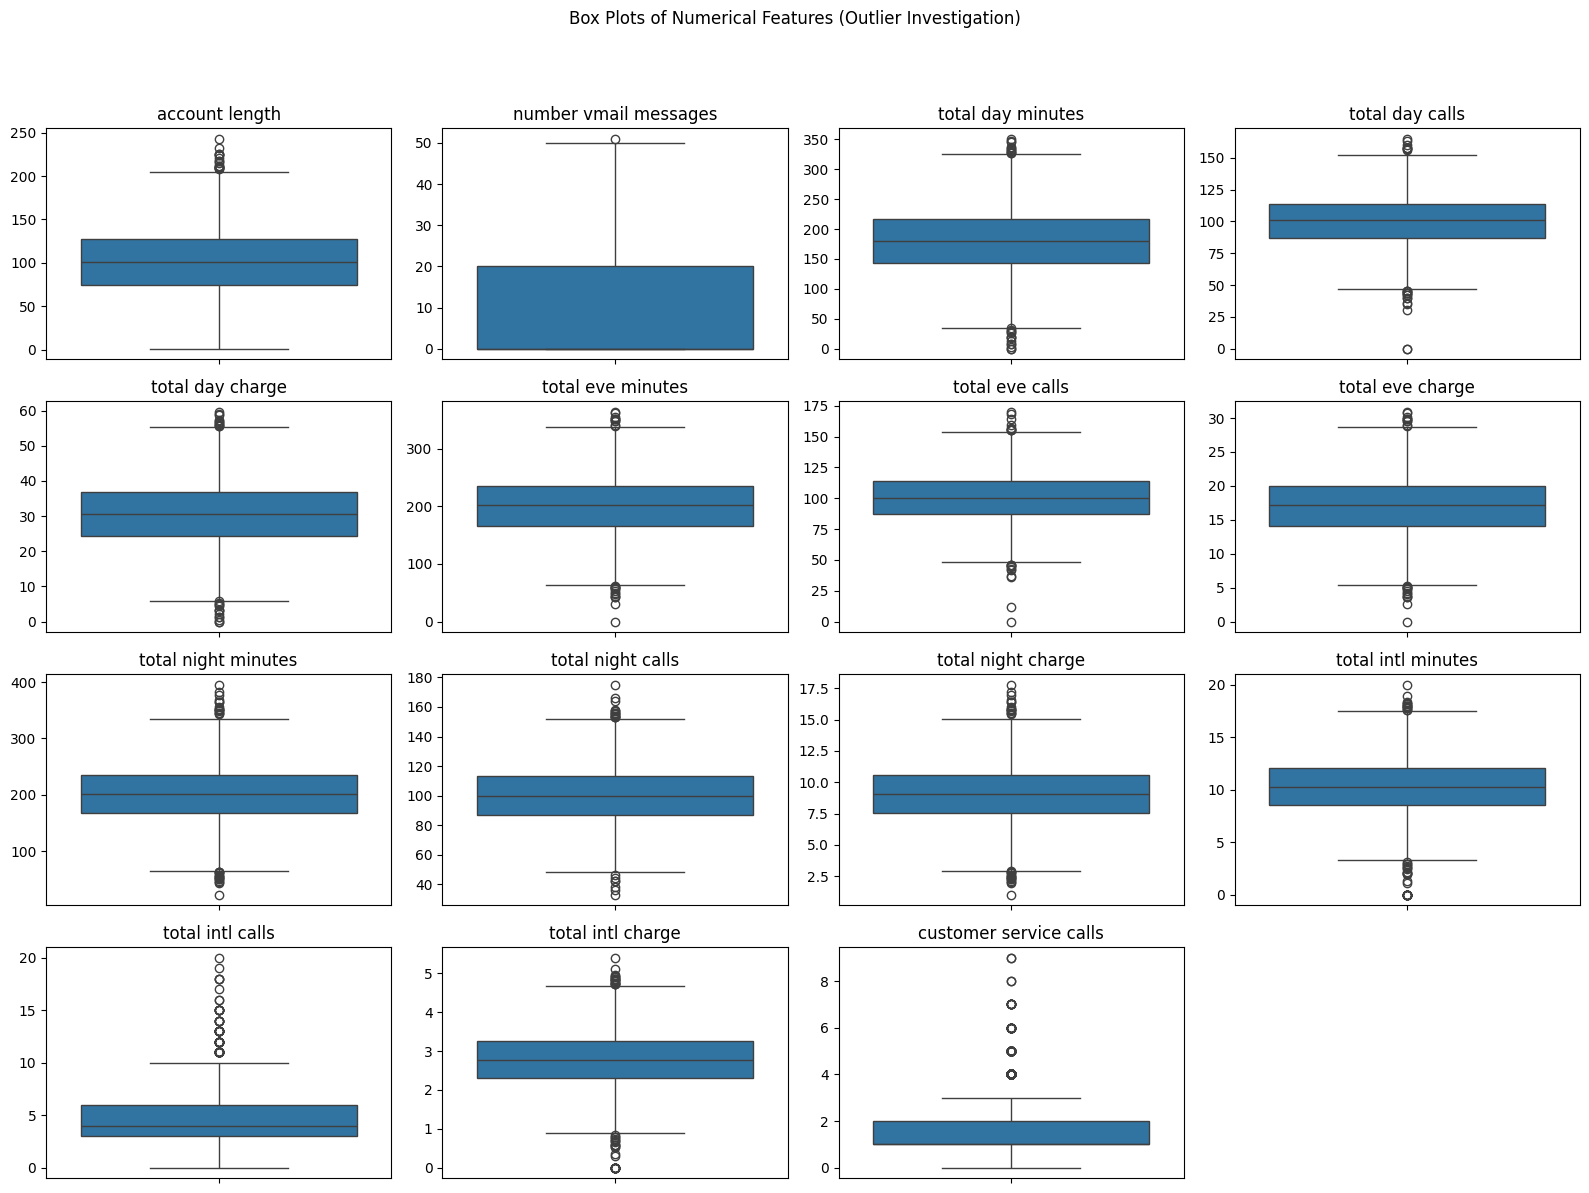

[1 0 2 3 4 5 7 9 6 8]


In [ ]:
# Check for outliers
print ("\n* * * * Check for Outliers * * * * \n")
numerical_cols = data_encoded.select_dtypes(include=['number']).columns

outlier_indices = []
for col in numerical_cols:
    Q1 = data_encoded[col].quantile(0.25)
    Q3 = data_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers for the current column
    col_outliers = data_encoded[(data_encoded[col] < lower_bound) | (data_encoded[col] > upper_bound)].index
    outlier_indices.extend(col_outliers.tolist())

# Get unique indices of rows containing at least one outlier
outlier_indices = list(set(outlier_indices))
print("Number of rows with outliers:", len(outlier_indices))

# Box plot to explore outliers
print ("\n* * * * Box Plot of Outliers * * * * \n")

# Exclude 'churn' from numerical_cols if it's treated as a target and not a feature for outlier detection
if 'churn' in numerical_cols:
    numerical_cols.remove('churn')

# Determine the number of rows and columns for the subplots
num_plots = len(numerical_cols)
num_cols = 4 # Adjust as needed
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 4, num_rows * 3))
plt.suptitle('Box Plots of Numerical Features (Outlier Investigation)', y=1.02)

for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=data_encoded[col])
    plt.title(col)
    plt.ylabel('') # Remove y-label to avoid clutter
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()


### Customer Service Calls
print(data['customer service calls'].unique())

## Exploratory Data Analysis (EDA)
- Visualize distributions of features
  - Look for class imbalance in **churn**
  - Consider distributions of other features
- Examine relationships between features (scatter plots, correlation matrix).
- Analyze the target variable distribution and check for target class imbalance.


<a name="class-imbalance"></a>
### Class Imbalance in **churn**


* * * * Checking for class Imbalance In Churn * * * * 



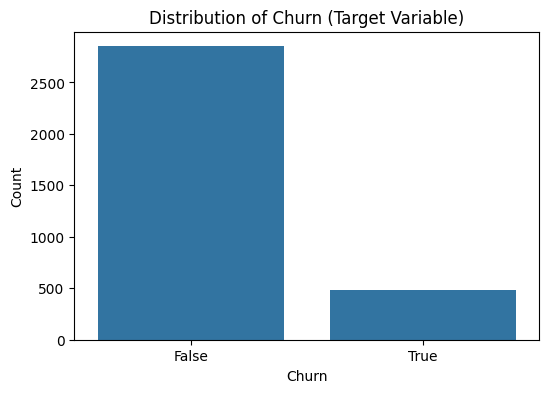

In [ ]:
# Class Imbalance
print ("\n* * * * Checking for class Imbalance In Churn * * * * \n")
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=data_encoded)
plt.title('Distribution of Churn (Target Variable)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

### Distributions of Feature **Values**

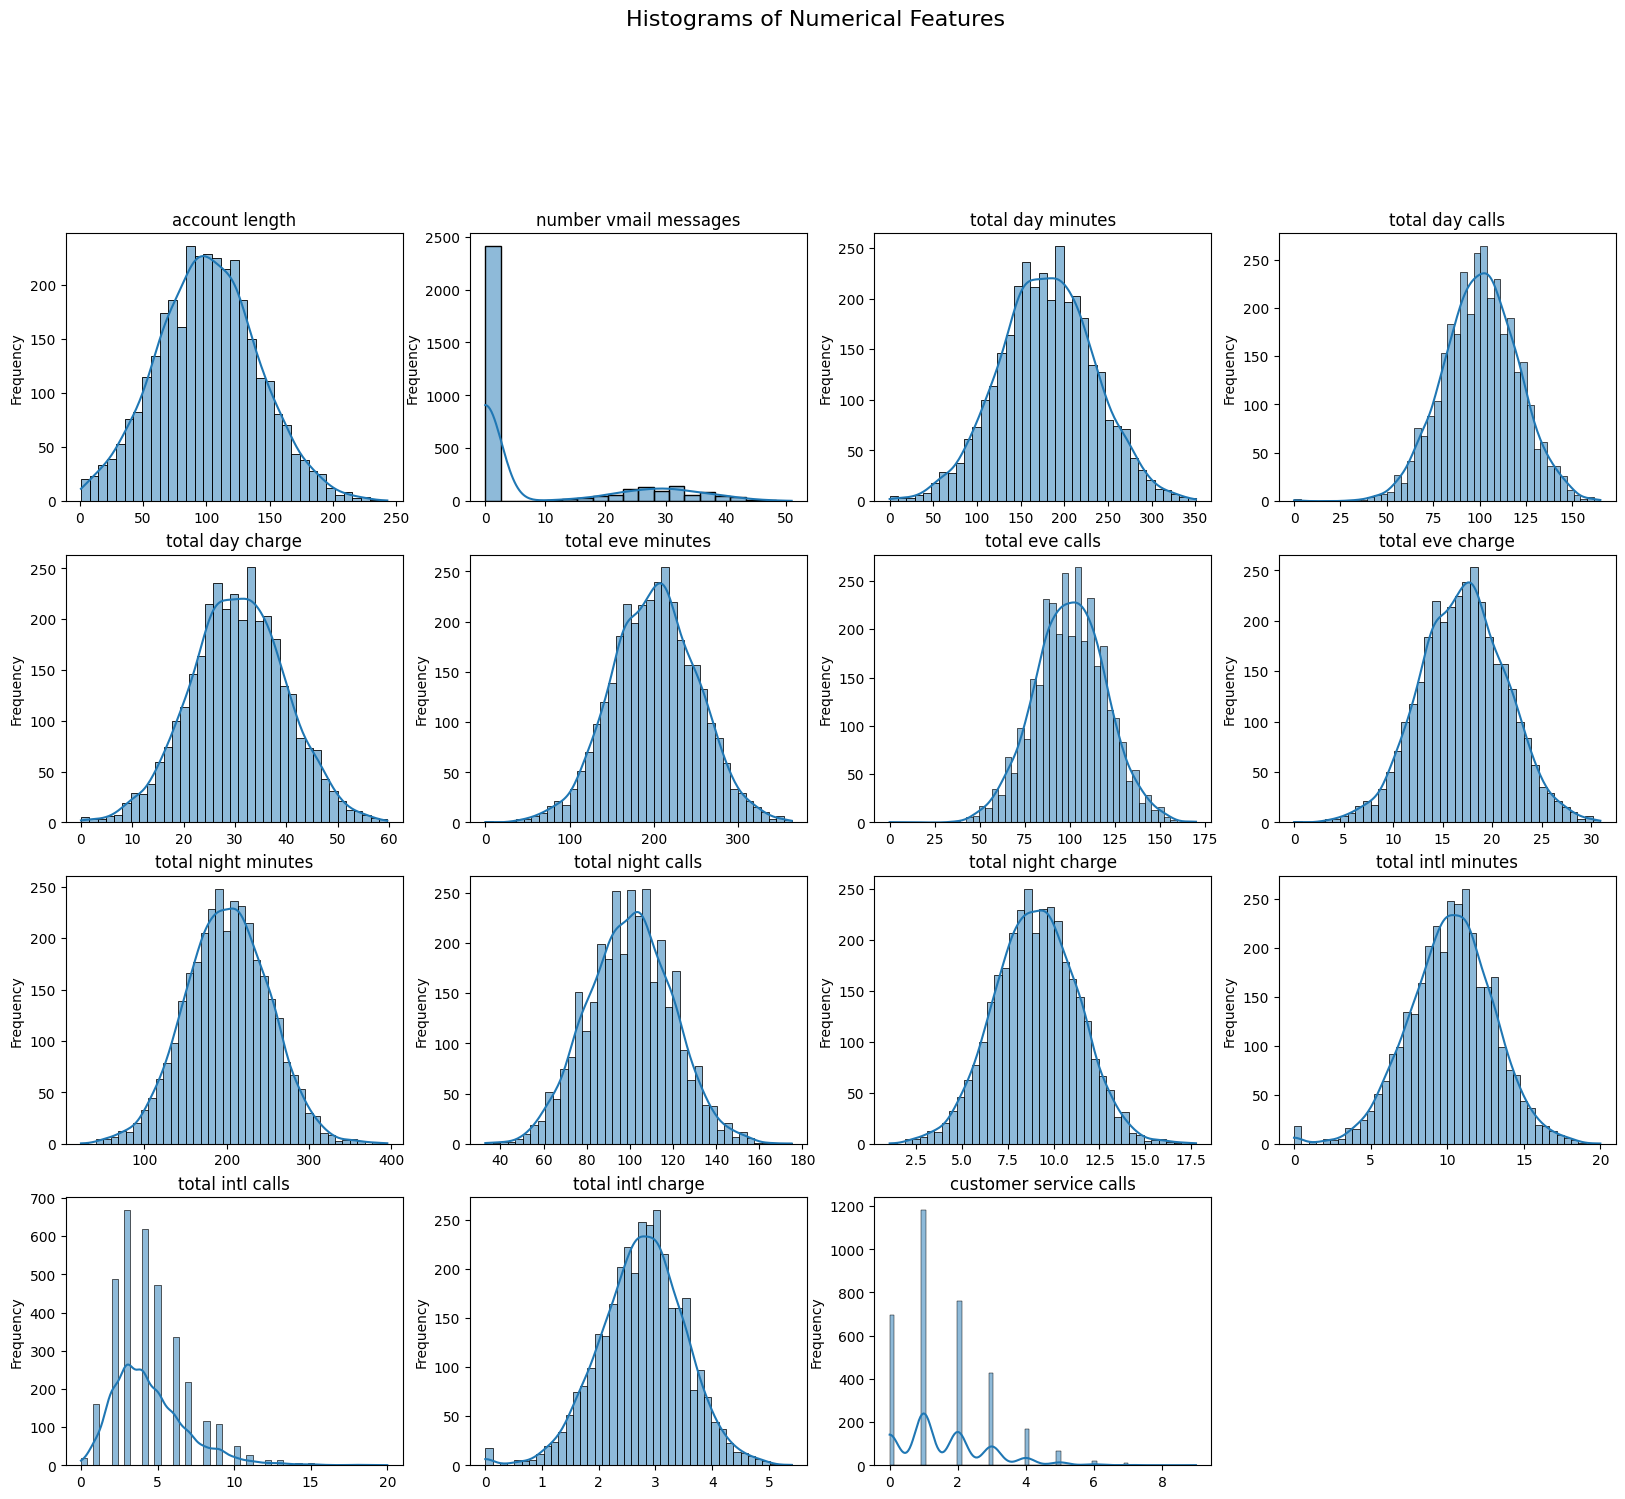

In [ ]:
# Plot the distributions of feature values
numerical_features = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'churn' in numerical_features:
    numerical_features.remove('churn')

# Determine the number of rows and columns for the subplots
num_plots = len(numerical_features)
num_cols = 4 # You can adjust this number
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 5, num_rows * 4))
plt.suptitle('Histograms of Numerical Features', y=1.02, fontsize=16)

for i, col in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data_encoded[col], kde=True)
    plt.title(col)
    plt.xlabel('') # Remove x-label to avoid clutter
    plt.ylabel('Frequency')

plt.show()

### Scatter Plot of Account Length, Total Minutes and Churn



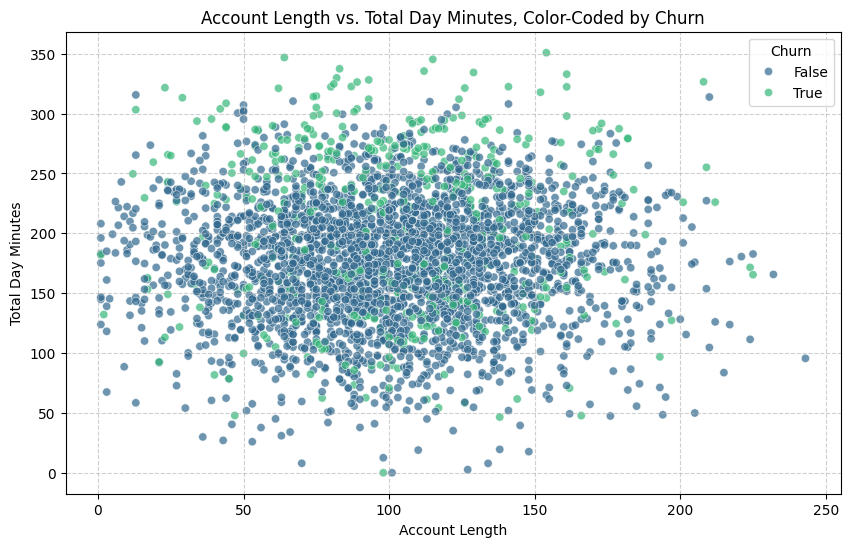

In [ ]:
# Scatter Plot of Account Length, Total Minutes, and Churn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_encoded,
    x='account length',
    y='total day minutes',
    hue='churn',
    alpha=0.7,
    palette='viridis' # Choose a color palette
)
plt.title('Account Length vs. Total Day Minutes, Color-Coded by Churn')
plt.xlabel('Account Length')
plt.ylabel('Total Day Minutes')
plt.legend(title='Churn')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Exploring customer service calls and churn

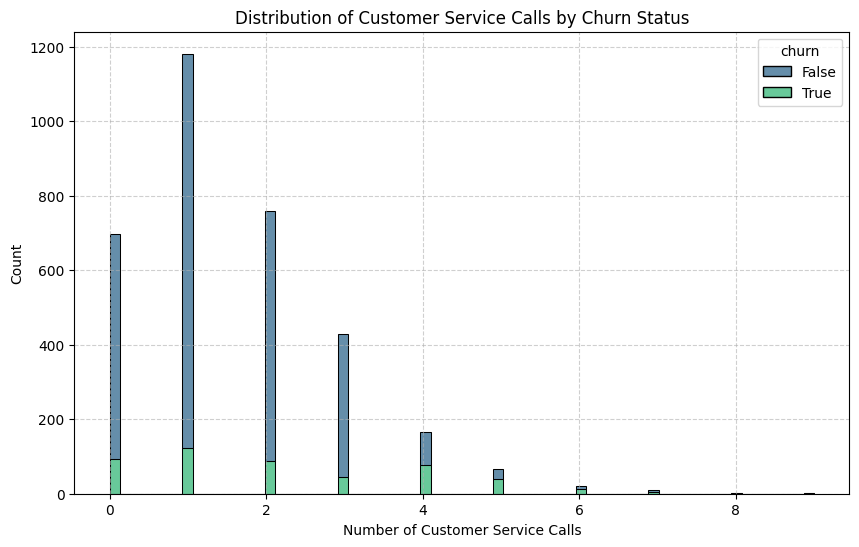

In [ ]:
# Histogram of customer service calls and churn
plt.figure(figsize=(10, 6))
sns.histplot(data=data_encoded, x='customer service calls', hue='churn', multiple='stack', palette='viridis')
plt.title('Distribution of Customer Service Calls by Churn Status')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Exploring Correlation
- Convert the 'churn' column to a numerical format (0 for False, 1 for True).
- Filter out all columns that start with 'state_' or contain 'charge' in their name.
  - State is not highly correlated, and charting this clutters results
  - Charges are captured in minutes and calls (which are used to determine the charges).
- Calculate the pairwise correlation matrix for the remaining features.
Visualizing the full correlation matrix as a heatmap.
- Extract and visualize the correlations

In [56]:
# Convert the 'churn' column to a numerical format
print ("\n* * * * Converting Churn to Numeric * * * * \n")
data_encoded['churn'] = data_encoded['churn'].astype(int)

# Verify the conversion
print("Unique values in 'churn' column after conversion:")
print(data_encoded['churn'].unique())
print("\nData type of 'churn' column after conversion:")
print(data_encoded['churn'].dtype)


* * * * Converting Churn to Numeric * * * * 

Unique values in 'churn' column after conversion:
[0 1]

Data type of 'churn' column after conversion:
int64


In [57]:
print ("\n* * * * Filtering Irrelevant Columns * * * * \n")

# Identify columns to filter out
columns_to_filter = [col for col in data_encoded.columns if col.startswith('state_') or 'charge' in col]

# Create a new DataFrame without these columns, ensuring 'churn' is kept for correlation
data_filtered = data_encoded.drop(columns=columns_to_filter, errors='ignore')

print("Shape of data after filtering columns:", data_filtered.shape)
print("Columns after filtering:", data_filtered.columns.tolist())
display(data_filtered.head())


* * * * Filtering Irrelevant Columns * * * * 

Shape of data after filtering columns: (3333, 16)
Columns after filtering: ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'customer service calls', 'churn', 'area code_415', 'area code_510', 'international plan_yes', 'voice mail plan_yes']


,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,True,False,False,True
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,True,False,False,True
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,True,False,False,False
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,False,False,True,False
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,True,False,True,False


In [58]:
print ("\n* * * * Calculating Correlation Matrix * * * * \n")

# Calculate the pairwise correlation matrix for the filtered data
correlation_matrix = data_filtered.corr()

print("Correlation matrix calculated. Shape:", correlation_matrix.shape)
display(correlation_matrix.head())



* * * * Calculating Correlation Matrix * * * * 

Correlation matrix calculated. Shape: (16, 16)


,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn,area code_415,area code_510,international plan_yes,voice mail plan_yes
account length,1.000000,-0.004628,0.006216,0.038470,-0.006757,0.019260,-0.008955,-0.013176,0.009514,0.020661,-0.003796,0.016541,0.000102,-0.011931,0.024735,0.002918
number vmail messages,-0.004628,1.000000,0.000778,-0.009548,0.017562,-0.005864,0.007681,0.007123,0.002856,0.013957,-0.013263,-0.089728,0.018772,-0.003391,0.008745,0.956927
total day minutes,0.006216,0.000778,1.000000,0.006750,0.007043,0.015769,0.004323,0.022972,-0.010155,0.008033,-0.013423,0.205151,0.033145,-0.010525,0.049396,-0.001684
total day calls,0.038470,-0.009548,0.006750,1.000000,-0.021451,0.006462,0.022938,-0.019557,0.021565,0.004574,-0.018942,0.018459,0.006968,-0.009778,0.003755,-0.011086
total eve minutes,-0.006757,0.017562,0.007043,-0.021451,1.000000,-0.011430,-0.012584,0.007586,-0.011035,0.002541,-0.012985,0.092796,-0.006429,0.003933,0.019100,0.021545



* * * * Visualizing Full Correlation Matrix * * * * 



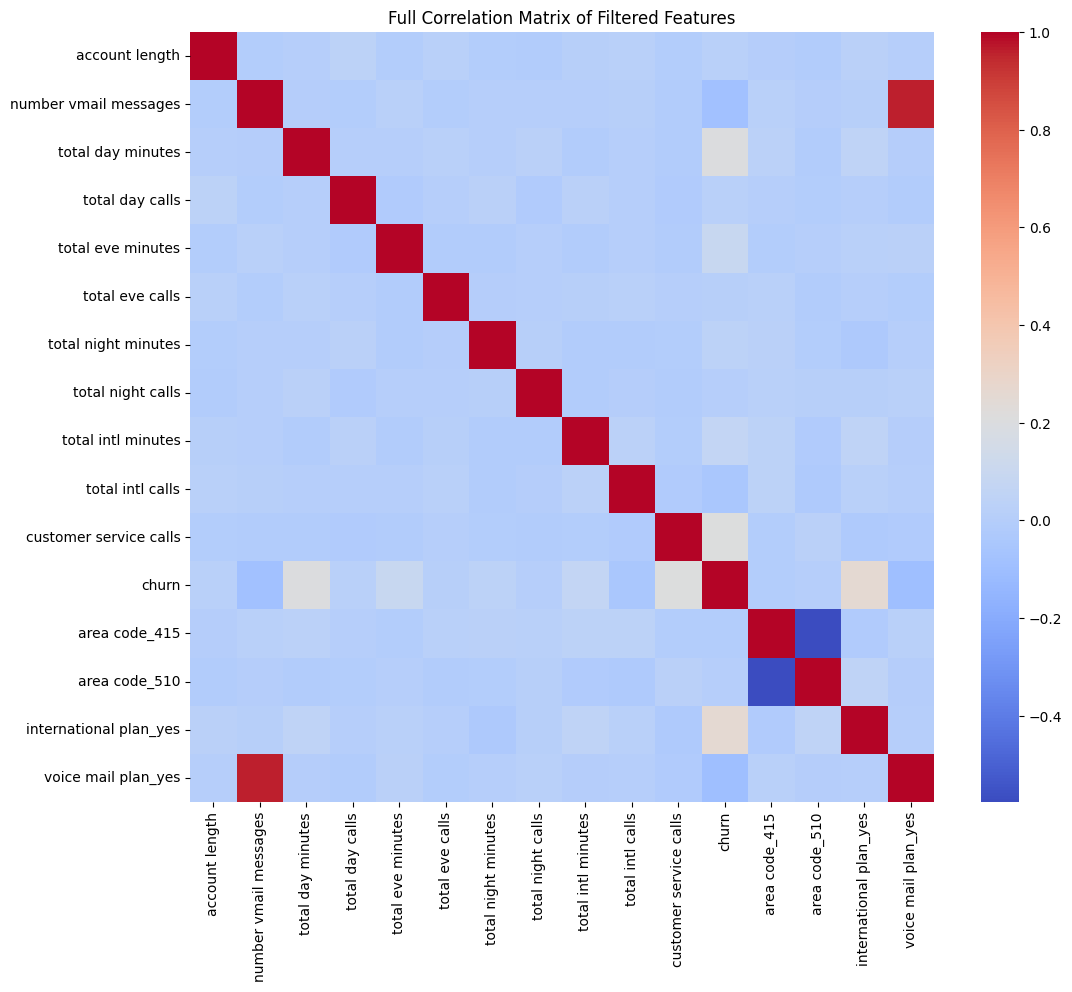

In [59]:
print ("\n* * * * Visualizing Full Correlation Matrix * * * * \n")

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Full Correlation Matrix of Filtered Features')
plt.show()


* * * * Visualizing Churn Correlations * * * * 



/tmp/ipython-input-550684265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_correlations.index, y=churn_correlations.values, palette='viridis')


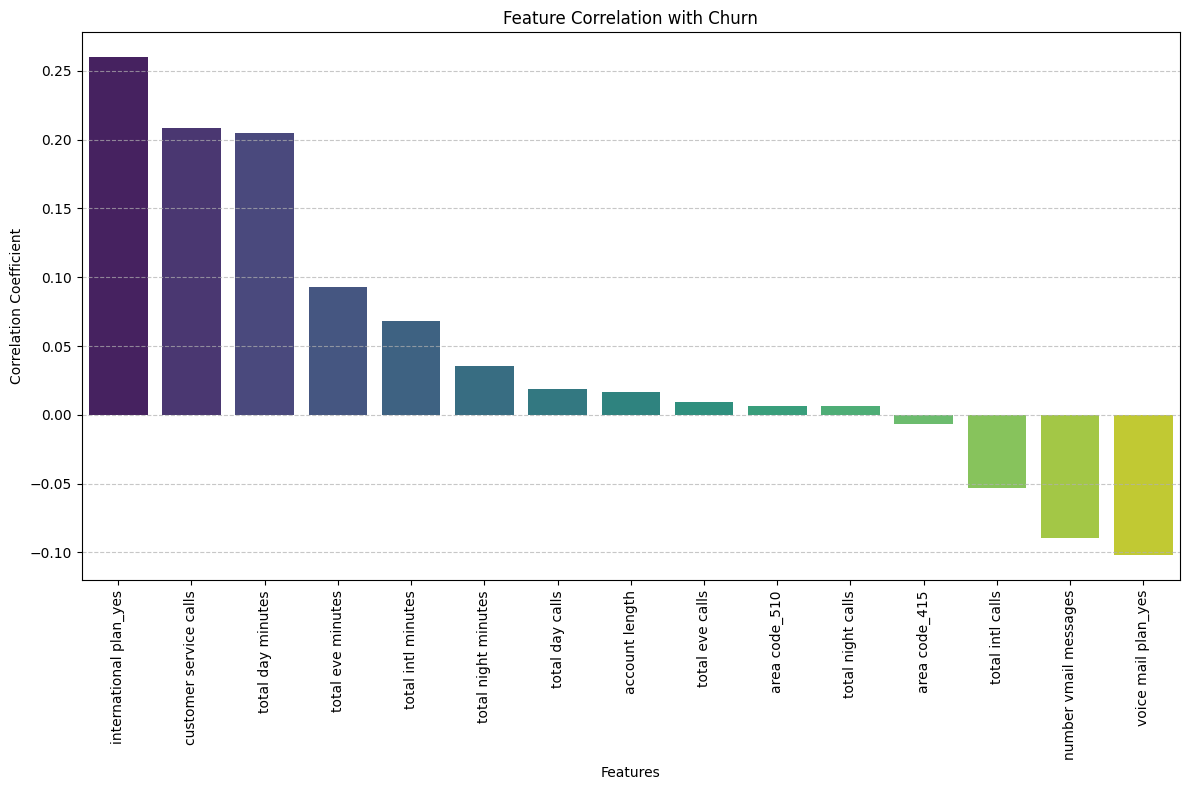

In [60]:
print ("\n* * * * Visualizing Churn Correlations * * * * \n")

# Extract correlations with 'churn'
churn_correlations = correlation_matrix['churn'].sort_values(ascending=False)

# Remove 'churn' itself from the list for plotting
churn_correlations = churn_correlations.drop('churn')

# Plotting the correlations with 'churn'
plt.figure(figsize=(12, 8))
sns.barplot(x=churn_correlations.index, y=churn_correlations.values, palette='viridis')
plt.title('Feature Correlation with Churn')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Building Train and Test Sets - Data Sampling
- We can use Synthetic Minority Over-sampling Technique(SMOTE) to account for the [Class Imbalance](#class-imbalance).
  - First we split the **churn** (the target) from the other features
  - Next divide the data into test and train sets.
  - Oversample **churn** into the training set using SMOTE
  - Check to make sure ratios look right (Train should be 50/50, Test should maintain original split)
- We need to scale features to ensure that larger numbers do not skew model resutls.


### Build Sets (SMOTE)

#### Split out **churn** (target) from features

In [62]:
print ("\n* * * * Separating Features (X) and Target (y) * * * * \n")
# Separate features (X) and target (y)
X = data_encoded.drop('churn', axis=1)
y = data_encoded['churn']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

print("First 5 rows of X:")
display(X.head())
print("First 5 rows of y:")
display(y.head())


* * * * Separating Features (X) and Target (y) * * * * 

Shape of X (features): (3333, 69)
Shape of y (target): (3333,)
First 5 rows of X:


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,False,False,False,False,False,False,True,False,False,True
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,False,False,False,False,False,False,True,False,False,True
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,False,False,False,False,False,False,True,False,False,False
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,False,False,False,False,False,False,False,False,True,False
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,False,False,False,False,False,False,True,False,True,False


First 5 rows of y:


,churn
0,0
1,0
2,0
3,0
4,0


#### Split into Train/Test

In [63]:
print("\n* * * * Splitting data into training and testing sets * * * * \n")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
display(X_train.head())
print("\nFirst 5 rows of y_train:")
display(y_train.head())


* * * * Splitting data into training and testing sets * * * * 

Shape of X_train: (2666, 69)
Shape of y_train: (2666,)
Shape of X_test: (667, 69)
Shape of y_test: (667,)

First 5 rows of X_train:


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
3286,106,30,220.1,105,37.42,222.2,109,18.89,158.4,96,...,False,False,False,False,False,False,True,False,False,True
86,94,0,157.9,105,26.84,155.0,101,13.18,189.6,84,...,False,False,False,False,False,False,False,False,False,False
1349,71,22,141.4,107,24.04,163.0,105,13.86,220.0,99,...,False,False,False,False,False,False,False,True,False,True
1649,130,0,68.4,86,11.63,193.3,110,16.43,171.5,139,...,False,False,False,False,False,False,False,False,False,False
3000,87,0,223.2,109,37.94,127.5,86,10.84,289.3,83,...,False,False,False,False,False,False,False,True,False,False



First 5 rows of y_train:


,churn
3286,0
86,1
1349,0
1649,0
3000,0


#### SMOTE
We want to use SMOTE to create synthetic samples for our minority class (**churn** = false) by interpolating between existing minority class samples.

In [64]:
print("\n* * * * Applying SMOTE to training data * * * * \n")

# Initialize SMOTE with random_state=42 for reproducibility
smote = SMOTE(random_state=42)

# Apply fit_resample to X_train and y_train
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Shape:\n")
print("Shape of original y_train:", y_train.shape)
print("Shape of resampled y_train:", y_train_resampled.shape)

print("Counts:\n", y_train_resampled.shape)
print("\nValue counts of original y_train:")
print(y_train.value_counts())
print("\nValue counts of resampled y_train:")
print(y_train_resampled.value_counts())

print("\nFirst 5 rows of X_train_resampled:")
display(X_train_resampled.head())
print("\nFirst 5 rows of y_train_resampled:")
display(y_train_resampled.head())


* * * * Applying SMOTE to training data * * * * 

Shape of original y_train: (2666,)
Shape of resampled y_train: (4560,)

Value counts of original y_train:
churn
0    2280
1     386
Name: count, dtype: int64

Value counts of resampled y_train:
churn
0    2280
1    2280
Name: count, dtype: int64

First 5 rows of X_train_resampled:


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,106,30,220.1,105,37.42,222.2,109,18.89,158.4,96,...,False,False,False,False,False,False,True,False,False,True
1,94,0,157.9,105,26.84,155.0,101,13.18,189.6,84,...,False,False,False,False,False,False,False,False,False,False
2,71,22,141.4,107,24.04,163.0,105,13.86,220.0,99,...,False,False,False,False,False,False,False,True,False,True
3,130,0,68.4,86,11.63,193.3,110,16.43,171.5,139,...,False,False,False,False,False,False,False,False,False,False
4,87,0,223.2,109,37.94,127.5,86,10.84,289.3,83,...,False,False,False,False,False,False,False,True,False,False



First 5 rows of y_train_resampled:


,churn
0,0
1,1
2,0
3,0
4,0


#### Test to ensure ratios look good.

We should see a training set that is a 50/50 split, while the test set should maintain the original distribution.


* * * * Original Churn Distribution (data_encoded) * * * * 

churn
0    2850
1     483
Name: count, dtype: int64
churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64

* * * * Churn Distribution in Training Set (y_train_resampled) after SMOTE * * * * 

churn
0    2280
1    2280
Name: count, dtype: int64
churn
0    0.5
1    0.5
Name: proportion, dtype: float64

* * * * Churn Distribution in Test Set (y_test) * * * * 

churn
0    570
1     97
Name: count, dtype: int64
churn
0    0.854573
1    0.145427
Name: proportion, dtype: float64


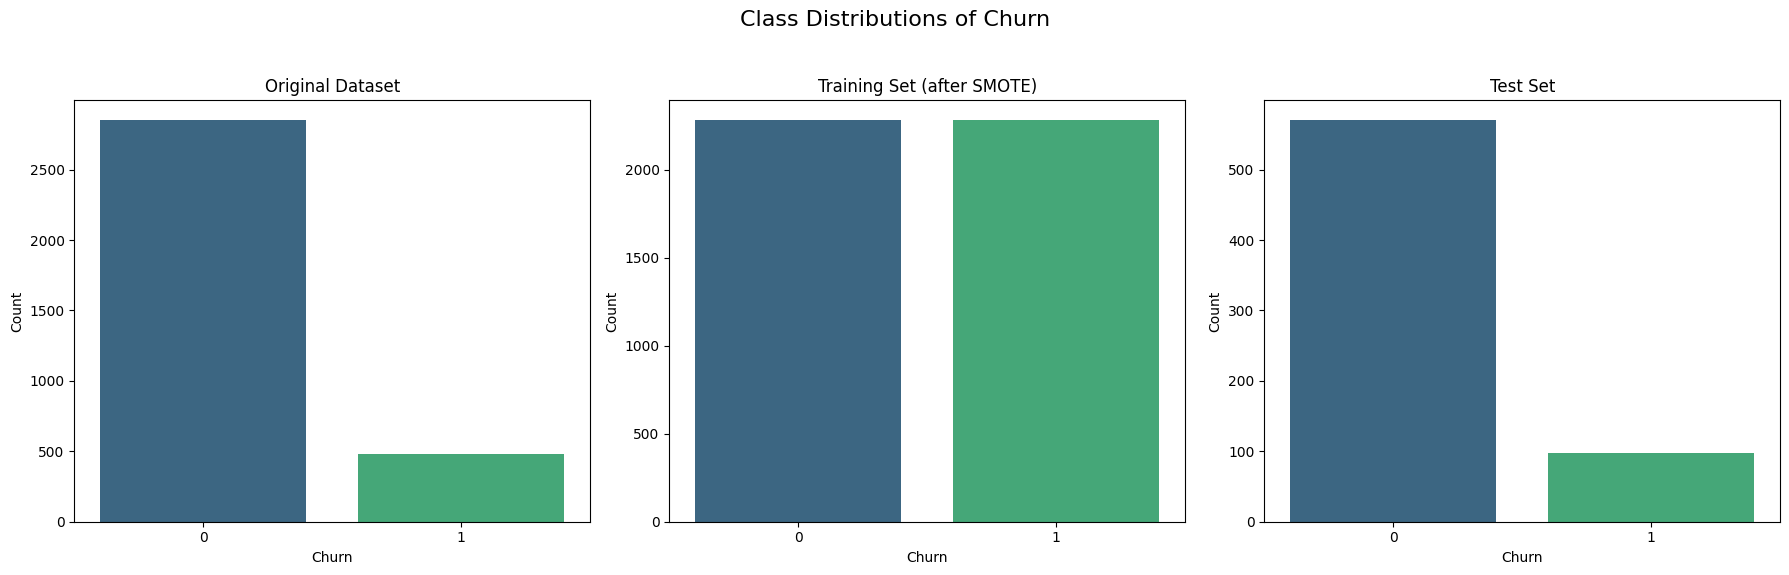

In [68]:
print("\n* * * * Original Churn Distribution (data_encoded) * * * * \n")
print(data_encoded['churn'].value_counts())
print(data_encoded['churn'].value_counts(normalize=True))

print("\n* * * * Churn Distribution in Training Set (y_train_resampled) after SMOTE * * * * \n")
print(y_train_resampled.value_counts())
print(y_train_resampled.value_counts(normalize=True))

print("\n* * * * Churn Distribution in Test Set (y_test) * * * * \n")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

# Create subplots for visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Class Distributions of Churn', fontsize=16)

# Plot 1: Original Churn Distribution
sns.countplot(x=data_encoded['churn'], ax=axes[0], palette='viridis')
axes[0].set_title('Original Dataset')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')

# Plot 2: Churn Distribution in Resampled Training Set
sns.countplot(x=y_train_resampled, ax=axes[1], palette='viridis')
axes[1].set_title('Training Set (after SMOTE)')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Count')

# Plot 3: Churn Distribution in Test Set
sns.countplot(x=y_test, ax=axes[2], palette='viridis')
axes[2].set_title('Test Set')
axes[2].set_xlabel('Churn')
axes[2].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Feature Scaling
We need to scale all the features, so that models do not give heavier weight to large scale numbers.


In [65]:
print("\n* * * * Scaling Features * * * * \n")

# 2. Initialize StandardScaler
scaler = StandardScaler()

# 3. Fit the scaler to X_train_resampled and transform X_train_resampled
X_train_scaled = scaler.fit_transform(X_train_resampled)

# 4. Transform X_test using the *fitted* scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier inspection and to retain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_resampled.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 5. Print the shapes of the scaled datasets and display the first 5 rows
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

print("\nFirst 5 rows of X_train_scaled:")
display(X_train_scaled.head())
print("\nFirst 5 rows of X_test_scaled:")
display(X_test_scaled.head())


* * * * Scaling Features * * * * 

Shape of X_train_scaled: (4560, 69)
Shape of X_test_scaled: (667, 69)

First 5 rows of X_train_scaled:


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,0.110904,1.921769,0.479857,0.206787,0.480084,0.322562,0.469630,0.323238,-0.905329,-0.209256,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,0.796130,-0.671105,-0.565194,1.723985
1,-0.206263,-0.525775,-0.517480,0.206787,-0.517809,-1.029369,0.036728,-1.028276,-0.246548,-0.850810,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,-0.671105,-0.565194,-0.580051
2,-0.814168,1.269091,-0.782047,0.310653,-0.781902,-0.868425,0.253179,-0.867325,0.395341,-0.048867,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,1.490080,-0.565194,1.723985
3,0.745239,-0.525775,-1.952554,-0.779941,-1.952398,-0.258849,0.523743,-0.259025,-0.628725,2.089648,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,-0.671105,-0.565194,-0.580051
4,-0.391278,-0.525775,0.529563,0.414519,0.529129,-1.582615,-0.774964,-1.582136,1.858595,-0.904273,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,1.490080,-0.565194,-0.580051



First 5 rows of X_test_scaled:


,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,-1.052043,-0.525775,-0.488618,-0.779941,-0.488570,-0.174353,-1.316092,-0.173816,-1.682353,0.271910,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,0.796130,-0.671105,1.769303,-0.580051
1,0.507364,-0.525775,0.369220,-1.143473,0.368787,-1.719417,0.848420,-1.719418,0.910542,0.111522,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,-0.671105,-0.565194,-0.580051
2,-0.047679,-0.525775,-1.330421,-0.156745,-1.330837,-2.401418,1.173096,-2.401092,-0.951781,0.913465,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,-1.256076,1.490080,1.769303,-0.580051
3,0.930254,-0.525775,0.298669,0.985783,0.298992,0.384928,-0.017385,0.384778,0.429125,1.608482,...,-0.147425,-0.159406,5.227139,-0.155752,-0.196785,-0.156489,-1.256076,-0.671105,-0.565194,-0.580051
4,2.304646,-0.525775,0.290651,0.258720,0.290503,0.614273,1.227209,0.614370,-0.468253,1.073853,...,-0.147425,-0.159406,-0.191309,-0.155752,-0.196785,-0.156489,0.796130,-0.671105,-0.565194,-0.580051


## Random Forest Model

### Setup and train RF
- Setup and Train a Random Forest ensemble model using:
  - the Scaled X set (which has been resampled with SMOTE, and Scaled)
  - along with the resampled Y set (which has been resampled with SMOTE)

In [77]:

print("\n* * * * Initializing and Training Random Forest Model * * * * \n")

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the resampled and scaled training data
rf_model.fit(X_train_scaled, y_train_resampled)

print("Random Forest Model training complete.")


* * * * Initializing and Training Random Forest Model * * * * 

Random Forest Model training complete.


### Make predictions
- Using the trained model and the scaled test set (this set maintains the original ratio of **churn**).


In [99]:
print("\n* * * * Making Predictions on the Test Set * * * * \n")

# Make predictions on the scaled test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made for the test set.")


* * * * Making Predictions on the Test Set * * * * 

Predictions made for the test set.


### Evaluate Random Forest Model
- To evaluate the Random Forest model, we will use:
  - Accuracy
  - Precision
  - Recall
  - F1-score, and
  - ROC AUC.
- Heatmap of the Confusion matrix.


* * * * Evaluating Random Forest Model Performance * * * * 

Accuracy: 0.8951
Precision: 0.6337
Recall: 0.6598
F1-Score: 0.6465
ROC AUC Score: 0.8830


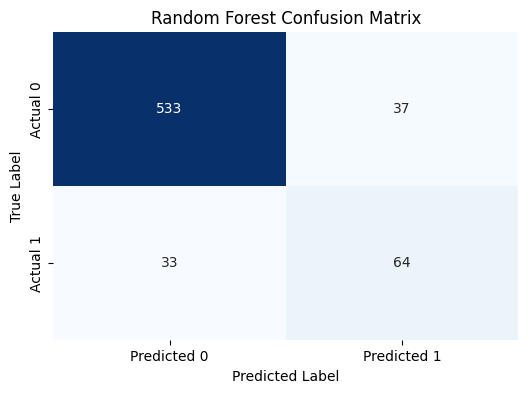

In [111]:
print("\n* * * * Evaluating Random Forest Model Performance * * * * \n")

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"ROC AUC Score: {roc_auc_rf:.4f}")

# Display Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Tune Random Forest max_depth Hyperparameter
We will evaluate different `max_depth` levels for the Random Forest Classifier to find the optimal depth that yields the best F1-score on the test set.


* * * * Tuning Random Forest max_depth * * * * 

Max Depth: 1, F1-Score: 0.4557
Max Depth: 2, F1-Score: 0.4649
Max Depth: 3, F1-Score: 0.5143
Max Depth: 4, F1-Score: 0.5118
Max Depth: 5, F1-Score: 0.5320
Max Depth: 6, F1-Score: 0.5688
Max Depth: 7, F1-Score: 0.5822
Max Depth: 8, F1-Score: 0.6233
Max Depth: 9, F1-Score: 0.6321
Max Depth: 10, F1-Score: 0.6389
Max Depth: 11, F1-Score: 0.6029
Max Depth: 12, F1-Score: 0.6377
Max Depth: 13, F1-Score: 0.6442
Max Depth: 14, F1-Score: 0.6311
Max Depth: 15, F1-Score: 0.6373
Max Depth: 16, F1-Score: 0.6634
Max Depth: 17, F1-Score: 0.6535
Max Depth: 18, F1-Score: 0.6667
Max Depth: 19, F1-Score: 0.6700
Max Depth: 20, F1-Score: 0.6462

Optimal max_depth: 19 with an F1-Score of 0.6700


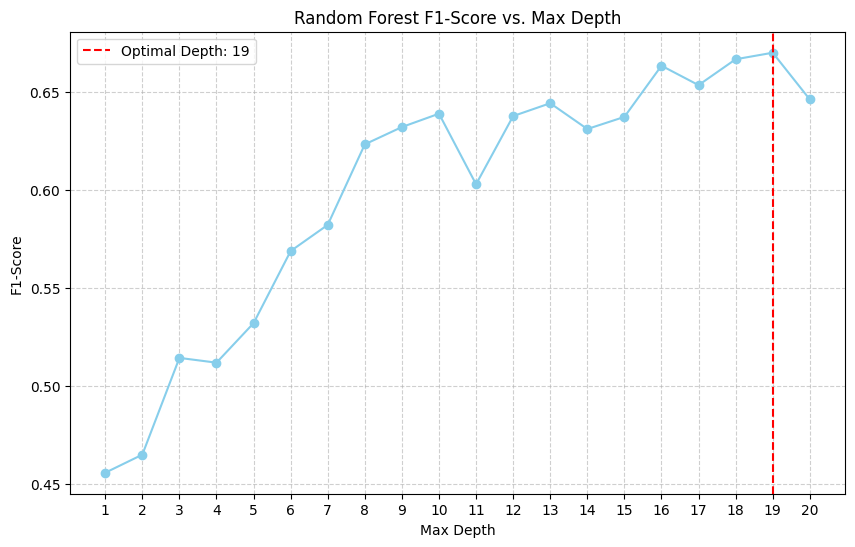

In [98]:
print("\n* * * * Tuning Random Forest max_depth * * * * \n")

# Define a range of max_depth values to test
max_depth_levels = np.arange(1, 21) # Test depths from 1 to 20
f1_scores_depth = []

# Iterate through each max_depth level
for depth in max_depth_levels:
    # Initialize Random Forest Classifier with the current max_depth
    rf_model_tuned = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42, class_weight='balanced')

    # Train the model
    rf_model_tuned.fit(X_train_scaled, y_train_resampled)

    # Make predictions on the scaled test set
    y_pred_tuned = rf_model_tuned.predict(X_test_scaled)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred_tuned)
    f1_scores_depth.append(f1)

    print(f"Max Depth: {depth}, F1-Score: {f1:.4f}")

# Find the optimal max_depth
optimal_depth_index = np.argmax(f1_scores_depth)
optimal_depth = max_depth_levels[optimal_depth_index]
best_f1_score = f1_scores_depth[optimal_depth_index]

print(f"\nOptimal max_depth: {optimal_depth} with an F1-Score of {best_f1_score:.4f}")

# Chart the F1 scores for each depth level
plt.figure(figsize=(10, 6))
plt.plot(max_depth_levels, f1_scores_depth, marker='o', linestyle='-', color='skyblue')
plt.title('Random Forest F1-Score vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1-Score')
plt.xticks(max_depth_levels)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(x=optimal_depth, color='red', linestyle='--', label=f'Optimal Depth: {optimal_depth}')
plt.legend()
plt.show()

### Train and evaluate Random Forest


* * * * Initializing and Training Optimal Random Forest Model * * * * 

Optimal Random Forest Model training complete.

* * * * Making Predictions with Optimal Random Forest Model on the Test Set * * * * 

Predictions made for the test set using Optimal Random Forest Model.

* * * * Evaluating Optimal Random Forest Model Performance * * * * 

Optimal RF Model Accuracy: 0.9010
Optimal RF Model Precision: 0.6505
Optimal RF Model Recall: 0.6907
Optimal RF Model F1-Score: 0.6700
Optimal RF Model ROC AUC Score: 0.8803


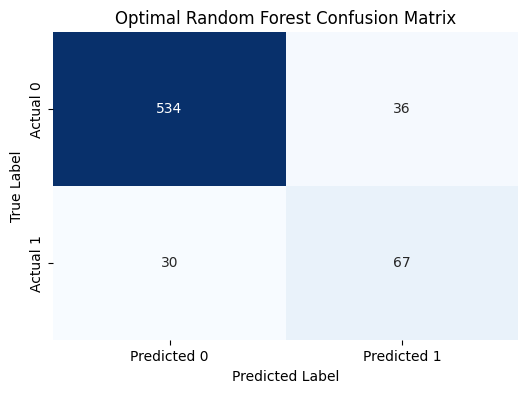

In [118]:
print("\n* * * * Initializing and Training Optimal Random Forest Model * * * * \n")

# Initialize the Random Forest Classifier with the optimal max_depth
optimal_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=optimal_depth,
    random_state=42,
    class_weight='balanced'
)

# Train the model using the resampled and scaled training data
optimal_rf_model.fit(X_train_scaled, y_train_resampled)

print("Optimal Random Forest Model training complete.")

print("\n* * * * Making Predictions with Optimal Random Forest Model on the Test Set * * * * \n")

# Make predictions on the scaled test set
y_pred_optimal_rf = optimal_rf_model.predict(X_test_scaled)
y_pred_proba_optimal_rf = optimal_rf_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made for the test set using Optimal Random Forest Model.")

print("\n* * * * Evaluating Optimal Random Forest Model Performance * * * * \n")

# Calculate evaluation metrics for Optimal Random Forest Model
accuracy_optimal_rf = accuracy_score(y_test, y_pred_optimal_rf)
precision_optimal_rf = precision_score(y_test, y_pred_optimal_rf)
recall_optimal_rf = recall_score(y_test, y_pred_optimal_rf)
f1_optimal_rf = f1_score(y_test, y_pred_optimal_rf)
roc_auc_optimal_rf = roc_auc_score(y_test, y_pred_proba_optimal_rf)

print(f"Optimal RF Model Accuracy: {accuracy_optimal_rf:.4f}")
print(f"Optimal RF Model Precision: {precision_optimal_rf:.4f}")
print(f"Optimal RF Model Recall: {recall_optimal_rf:.4f}")
print(f"Optimal RF Model F1-Score: {f1_optimal_rf:.4f}")
print(f"Optimal RF Model ROC AUC Score: {roc_auc_optimal_rf:.4f}")

# Display Confusion Matrix for Optimal Random Forest Model
cm_optimal_rf = confusion_matrix(y_test, y_pred_optimal_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimal_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Optimal Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Gradient Boosting

In [ ]:
### Set up and train GB
- Setup and Train a Gradient Boosting ensemble model using:
  - the Scaled X set (which has been resampled with SMOTE, and Scaled)
  - along with the resampled Y set (which has been resampled with SMOTE)

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

print("\n* * * * Initializing and Training Gradient Boosting Model * * * * \n")

# Initialize the Gradient Boosting Classifier
# n_estimators is the number of boosting stages to perform.
# learning_rate shrinks the contribution of each tree.
# random_state for reproducibility.
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model using the resampled and scaled training data
gb_model.fit(X_train_scaled, y_train_resampled)

print("Gradient Boosting Model training complete.")


* * * * Initializing and Training Gradient Boosting Model * * * * 

Gradient Boosting Model training complete.


### Make predictions
- Using the trained GB model and the scaled test set (this set maintains the original ratio of **churn**).

In [81]:
print("\n* * * * Making Predictions on the Test Set * * * * \n")

# Make predictions on the scaled test set
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made for the test set.")


* * * * Making Predictions on the Test Set * * * * 

Predictions made for the test set.


### Evaluate Gradient Boosting Model
- To evaluate the Gradient Boosting model, we will use:
  - Accuracy
  - Precision
  - Recall
  - F1-score, and
  - ROC AUC.
- Heatmap of the Confusion matrix.


* * * * Evaluating Gradient Boosting Model Performance * * * * 

Accuracy: 0.8846
Precision: 0.5820
Recall: 0.7320
F1-Score: 0.6484
ROC AUC Score: 0.8720


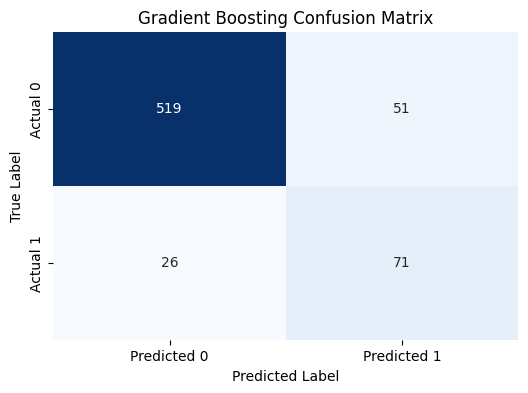

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\n* * * * Evaluating Gradient Boosting Model Performance * * * * \n")

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")
print(f"ROC AUC Score: {roc_auc_gb:.4f}")

# Display Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Tuning Gradient Boosting Hyperparameters
- Tune both
  - learning rate, and
  - estimators number
- Test various combinations, judging success base on F1 score
- Show heatmap of combinations to get a sense if there is a clear tuning trend.


In [113]:
print("\n* * * * Tuning Gradient Boosting Hyperparameters * * * * \n")

# 1. Define lists of learning_rate and n_estimators values to test
learning_rates = [0.01, 0.05, 0.1, 0.2]
n_estimators_list = [50, 100, 150, 200]

# 3. Initialize a list to store the results
gb_tuning_results = []

# Loop through each learning_rate and n_estimators combination
for lr in learning_rates:
    for n_est in n_estimators_list:
        print(f"\nTraining GB with learning_rate={lr}, n_estimators={n_est}")
        # 6. Instantiate a GradientBoostingClassifier
        gb_tuned_model = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_est, random_state=42)

        # 7. Train the model
        gb_tuned_model.fit(X_train_scaled, y_train_resampled)

        # 8. Make predictions on the scaled test set
        y_pred_gb_tuned = gb_tuned_model.predict(X_test_scaled)

        # 9. Calculate the F1-score
        f1_gb_tuned = f1_score(y_test, y_pred_gb_tuned)

        # 10. Store the results
        gb_tuning_results.append({
            'learning_rate': lr,
            'n_estimators': n_est,
            'f1_score': f1_gb_tuned
        })
        print(f"  F1-Score: {f1_gb_tuned:.4f}")

print("\nGradient Boosting hyperparameter tuning complete.")

# Convert results to a DataFrame for easier analysis and visualization
gb_tuning_df = pd.DataFrame(gb_tuning_results)
print("\nGB Tuning Results:")
display(gb_tuning_df)



* * * * Tuning Gradient Boosting Hyperparameters * * * * 


Training GB with learning_rate=0.01, n_estimators=50
  F1-Score: 0.5490

Training GB with learning_rate=0.01, n_estimators=100
  F1-Score: 0.5581

Training GB with learning_rate=0.01, n_estimators=150
  F1-Score: 0.5613

Training GB with learning_rate=0.01, n_estimators=200
  F1-Score: 0.5680

Training GB with learning_rate=0.05, n_estimators=50
  F1-Score: 0.5703

Training GB with learning_rate=0.05, n_estimators=100
  F1-Score: 0.6186

Training GB with learning_rate=0.05, n_estimators=150
  F1-Score: 0.6432

Training GB with learning_rate=0.05, n_estimators=200
  F1-Score: 0.6368

Training GB with learning_rate=0.1, n_estimators=50
  F1-Score: 0.6180

Training GB with learning_rate=0.1, n_estimators=100
  F1-Score: 0.6484

Training GB with learning_rate=0.1, n_estimators=150
  F1-Score: 0.6509

Training GB with learning_rate=0.1, n_estimators=200
  F1-Score: 0.6699

Training GB with learning_rate=0.2, n_estimators=50
  F1-S

,learning_rate,n_estimators,f1_score
0,0.01,50,0.549020
1,0.01,100,0.558140
2,0.01,150,0.561265
3,0.01,200,0.568000
4,0.05,50,0.570281
5,0.05,100,0.618644
6,0.05,150,0.643172
7,0.05,200,0.636771
8,0.10,50,0.618026
9,0.10,100,0.648402



* * * * Identifying Optimal Hyperparameters and Visualizing Results * * * * 

Optimal learning_rate: 0.2
Optimal n_estimators: 200
Highest F1-Score: 0.7172


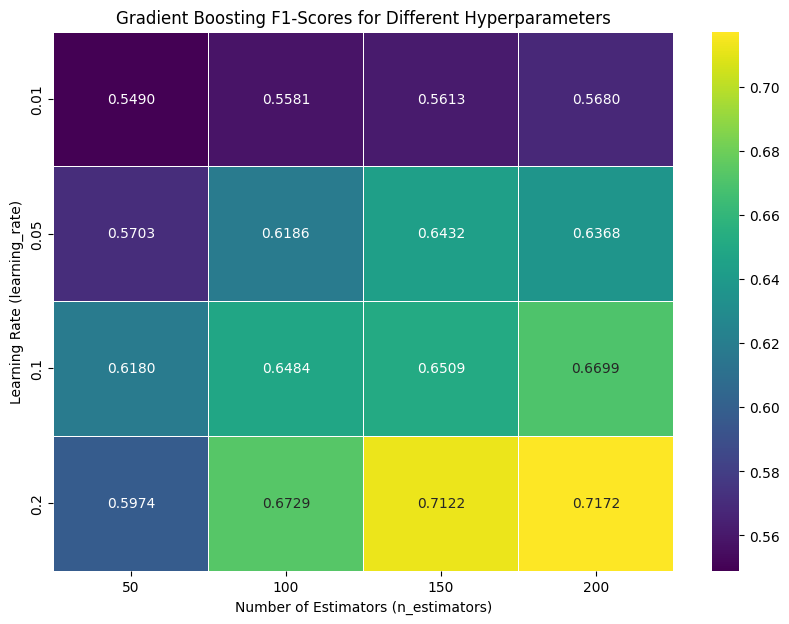

In [114]:
print("\n* * * * Identifying Optimal Hyperparameters and Visualizing Results * * * * \n")

# Find the optimal hyperparameters
optimal_gb_params = gb_tuning_df.loc[gb_tuning_df['f1_score'].idxmax()]
optimal_lr = optimal_gb_params['learning_rate']
optimal_n_estimators = optimal_gb_params['n_estimators']
best_f1_gb = optimal_gb_params['f1_score']

print(f"Optimal learning_rate: {optimal_lr}")
print(f"Optimal n_estimators: {int(optimal_n_estimators)}")
print(f"Highest F1-Score: {best_f1_gb:.4f}")

# Reshape the results for heatmap visualization
f1_scores_pivot = gb_tuning_df.pivot(index='learning_rate', columns='n_estimators', values='f1_score')

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(f1_scores_pivot, annot=True, cmap='viridis', fmt=".4f", linewidths=.5)
plt.title('Gradient Boosting F1-Scores for Different Hyperparameters')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Learning Rate (learning_rate)')
plt.show()


### Train and evaluate tuned GB model


* * * * Initializing and Training Optimal Gradient Boosting Model * * * * 

Optimal Gradient Boosting Model training complete.

* * * * Making Predictions with Optimal Gradient Boosting Model on the Test Set * * * * 

Predictions made for the test set using Optimal Gradient Boosting Model.

* * * * Evaluating Optimal Gradient Boosting Model Performance * * * * 

Optimal GB Model Accuracy: 0.9160
Optimal GB Model Precision: 0.7030
Optimal GB Model Recall: 0.7320
Optimal GB Model F1-Score: 0.7172
Optimal GB Model ROC AUC Score: 0.8839


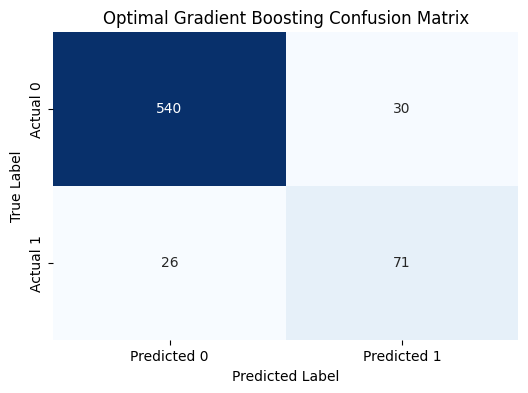

In [117]:
print("\n* * * * Initializing and Training Optimal Gradient Boosting Model * * * * \n")

# Initialize the Gradient Boosting Classifier with optimal hyperparameters
optimal_gb_model = GradientBoostingClassifier(
    n_estimators=int(optimal_n_estimators),
    learning_rate=optimal_lr,
    random_state=42
)

# Train the model using the resampled and scaled training data
optimal_gb_model.fit(X_train_scaled, y_train_resampled)

print("Optimal Gradient Boosting Model training complete.")

print("\n* * * * Making Predictions with Optimal Gradient Boosting Model on the Test Set * * * * \n")

# Make predictions on the scaled test set
y_pred_optimal_gb = optimal_gb_model.predict(X_test_scaled)
y_pred_proba_optimal_gb = optimal_gb_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made for the test set using Optimal Gradient Boosting Model.")

print("\n* * * * Evaluating Optimal Gradient Boosting Model Performance * * * * \n")

# Calculate evaluation metrics for Optimal Gradient Boosting Model
accuracy_optimal_gb = accuracy_score(y_test, y_pred_optimal_gb)
precision_optimal_gb = precision_score(y_test, y_pred_optimal_gb)
recall_optimal_gb = recall_score(y_test, y_pred_optimal_gb)
f1_optimal_gb = f1_score(y_test, y_pred_optimal_gb)
roc_auc_optimal_gb = roc_auc_score(y_test, y_pred_proba_optimal_gb)

print(f"Optimal GB Model Accuracy: {accuracy_optimal_gb:.4f}")
print(f"Optimal GB Model Precision: {precision_optimal_gb:.4f}")
print(f"Optimal GB Model Recall: {recall_optimal_gb:.4f}")
print(f"Optimal GB Model F1-Score: {f1_optimal_gb:.4f}")
print(f"Optimal GB Model ROC AUC Score: {roc_auc_optimal_gb:.4f}")

# Display Confusion Matrix for Optimal Gradient Boosting Model
cm_optimal_gb = confusion_matrix(y_test, y_pred_optimal_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimal_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Optimal Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Stacking Model

### Setup base models
- graident boost
- random forest
- decision tree

In [135]:
print("\n* * * * Initializing Base Models for Stacking * * * * \n")

# Initialize DecisionTreeClassifier
dt_base = DecisionTreeClassifier(random_state=42)
print("DecisionTreeClassifier initialized.")


* * * * Initializing Base Models for Stacking * * * * 

DecisionTreeClassifier initialized.


### Setup and Train the Stacking Ensemble Model
- Us Logistic Regression as the "meta model"
- Train stacking model on resampled and scale training set

In [130]:
print("\n* * * * Initializing Stacking Classifier * * * * \n")

# Define the base models (estimators)
estimators = [
    ('gb', optimal_gb_model),
    ('rf', optimal_rf_model),
    ('dt', dt_base)
]

# Initialize the meta-estimator
meta_estimator = LogisticRegression(random_state=42, solver='liblinear') # Using 'liblinear' solver for small datasets

# Initialize the StackingClassifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_estimator,
    cv=5, # Number of cross-validation folds to use for `predict_proba` and `predict` of the base estimators
    stack_method='auto', # Method for combining base estimators (e.g., 'auto', 'predict_proba', 'predict')
    n_jobs=-1, # Use all available cores
)

print("StackingClassifier initialized with GradientBoosting, RandomForest, and DecisionTree as base estimators and LogisticRegression as meta-estimator.")


* * * * Initializing Stacking Classifier * * * * 

StackingClassifier initialized with GradientBoosting, RandomForest, and DecisionTree as base estimators and LogisticRegression as meta-estimator.


In [131]:
print("\n* * * * Training Stacking Model * * * * \n")

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train_resampled)

print("Stacking Model training complete.")


* * * * Training Stacking Model * * * * 

Stacking Model training complete.


### Make predictions using stacked model
- Make predictions based on the test data (which was not SMOTE'd)

In [132]:
print("\n* * * * Making Predictions with Stacking Model on the Test Set * * * * \n")

# Make predictions on the scaled test set
y_pred_stack = stacking_model.predict(X_test_scaled)
y_pred_proba_stack = stacking_model.predict_proba(X_test_scaled)[:, 1]

print("Predictions made for the test set using Stacking Model.")


* * * * Making Predictions with Stacking Model on the Test Set * * * * 

Predictions made for the test set using Stacking Model.


### Evaluate the Stacking model
- To evaluate the Stacking model, we will look at:
  - Accuracy
  - Precision
  - Recall
  - F1-score, and
  - ROC AUC.
- Heatmap of the Confusion matrix.



* * * * Evaluating Stacking Model Performance * * * * 

Stacking Model Accuracy: 0.9100
Stacking Model Precision: 0.6667
Stacking Model Recall: 0.7629
Stacking Model F1-Score: 0.7115
Stacking Model ROC AUC Score: 0.8879


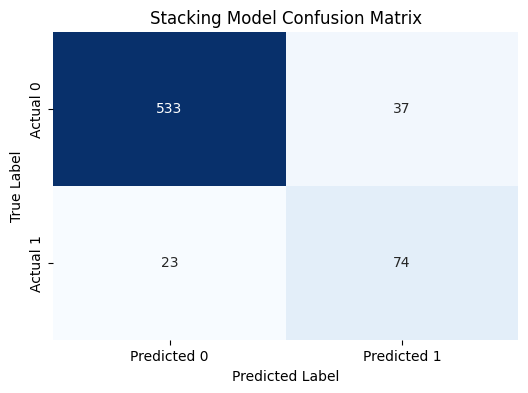

In [133]:
print("\n* * * * Evaluating Stacking Model Performance * * * * \n")

# Calculate evaluation metrics for Stacking Model
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack)
recall_stack = recall_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
roc_auc_stack = roc_auc_score(y_test, y_pred_proba_stack)

print(f"Stacking Model Accuracy: {accuracy_stack:.4f}")
print(f"Stacking Model Precision: {precision_stack:.4f}")
print(f"Stacking Model Recall: {recall_stack:.4f}")
print(f"Stacking Model F1-Score: {f1_stack:.4f}")
print(f"Stacking Model ROC AUC Score: {roc_auc_stack:.4f}")

# Display Confusion Matrix for Stacking Model
cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Stacking Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Trying different Meta Estimators

- Try using different estimators with the same basic stacking model
  - Logistic Regression
  - Decision Tree
  - Random Forest
- Evaluate these models based on F1 score

In [140]:
print("\n* * * * Iterating through different meta-estimators for Stacking Model * * * * \n")

# Define different classifiers to be used as meta-estimators
meta_estimators_list = [
    ('Logistic Regression', LogisticRegression(random_state=42, solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

# Dictionary to store F1-scores for each meta-estimator
meta_estimator_f1_scores = {}

# Loop through each meta-estimator
for name, meta_estimator in meta_estimators_list:
    print(f"\nTraining StackingClassifier with {name} as meta-estimator...")

    # Initialize StackingClassifier with existing base models and the current meta-estimator
    stacking_model_tuned = StackingClassifier(
        estimators=estimators, # 'estimators' from the previous step ('gb', 'rf', 'dt')
        final_estimator=meta_estimator,
        cv=5,
        stack_method='auto',
        n_jobs=-1,
    )

    # Train the StackingClassifier
    stacking_model_tuned.fit(X_train_scaled, y_train_resampled)

    # Make predictions on the scaled test set
    y_pred_tuned_stack = stacking_model_tuned.predict(X_test_scaled)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred_tuned_stack)
    meta_estimator_f1_scores[name] = f1

    print(f"  F1-Score with {name} as meta-estimator: {f1:.4f}")

print("\nMeta-estimator tuning complete.")
print("F1-scores for each meta-estimator:")
for name, f1 in meta_estimator_f1_scores.items():
    print(f"  {name}: {f1:.4f}")



* * * * Iterating through different meta-estimators for Stacking Model * * * * 


Training StackingClassifier with Logistic Regression as meta-estimator...
  F1-Score with Logistic Regression as meta-estimator: 0.7115

Training StackingClassifier with Decision Tree as meta-estimator...
  F1-Score with Decision Tree as meta-estimator: 0.6442

Training StackingClassifier with Random Forest as meta-estimator...
  F1-Score with Random Forest as meta-estimator: 0.6798

Meta-estimator tuning complete.
F1-scores for each meta-estimator:
  Logistic Regression: 0.7115
  Decision Tree: 0.6442
  Random Forest: 0.6798


In [141]:
print("\n* * * * Iterating through different meta-estimators for Stacking Model * * * * \n")

# Define different classifiers to be used as meta-estimators
meta_estimators_list = [
    ('Logistic Regression', LogisticRegression(random_state=42, solver='liblinear')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

# Dictionary to store F1-scores for each meta-estimator
meta_estimator_f1_scores = {}

# Loop through each meta-estimator
for name, meta_estimator in meta_estimators_list:
    print(f"\nTraining StackingClassifier with {name} as meta-estimator...")

    # Initialize StackingClassifier with existing base models and the current meta-estimator
    stacking_model_tuned = StackingClassifier(
        estimators=estimators, # 'estimators' from the previous step ('gb', 'rf', 'dt')
        final_estimator=meta_estimator,
        cv=5,
        stack_method='auto',
        n_jobs=-1
    )

    # Train the StackingClassifier
    stacking_model_tuned.fit(X_train_scaled, y_train_resampled)

    # Make predictions on the scaled test set
    y_pred_tuned_stack = stacking_model_tuned.predict(X_test_scaled)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred_tuned_stack)
    meta_estimator_f1_scores[name] = f1

    print(f"  F1-Score with {name} as meta-estimator: {f1:.4f}")

print("\nMeta-estimator tuning complete.")
print("F1-scores for each meta-estimator:")
for name, f1 in meta_estimator_f1_scores.items():
    print(f"  {name}: {f1:.4f}")



* * * * Iterating through different meta-estimators for Stacking Model * * * * 


Training StackingClassifier with Logistic Regression as meta-estimator...
  F1-Score with Logistic Regression as meta-estimator: 0.7115

Training StackingClassifier with Decision Tree as meta-estimator...
  F1-Score with Decision Tree as meta-estimator: 0.6442

Training StackingClassifier with Random Forest as meta-estimator...
  F1-Score with Random Forest as meta-estimator: 0.6798

Meta-estimator tuning complete.
F1-scores for each meta-estimator:
  Logistic Regression: 0.7115
  Decision Tree: 0.6442
  Random Forest: 0.6798



* * * * Visualizing Meta-Estimator F1-Scores * * * * 



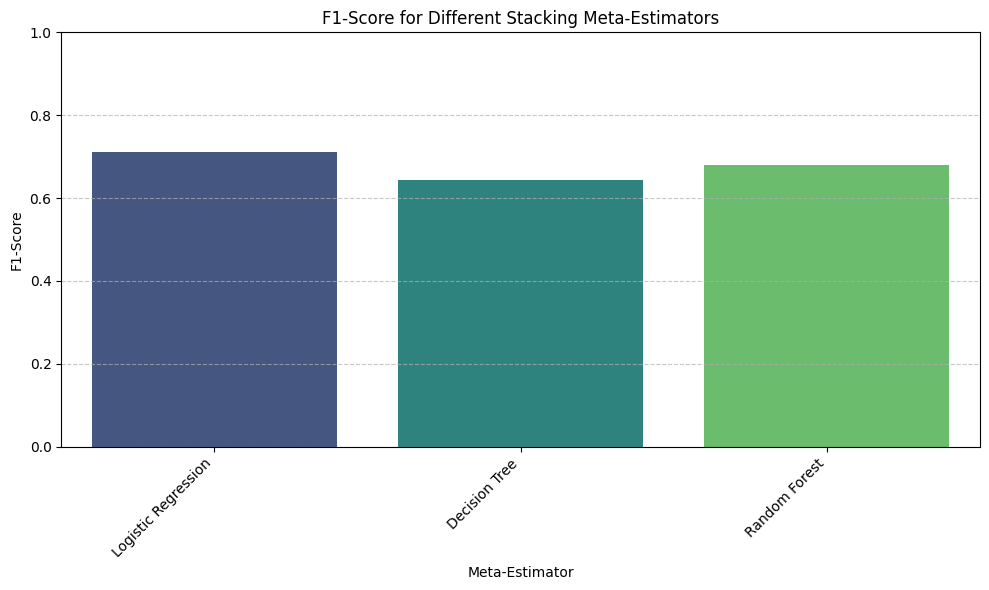

In [142]:
print("\n* * * * Visualizing Meta-Estimator F1-Scores * * * * \n")

# Convert the dictionary to a pandas Series for easy plotting
f1_scores_series = pd.Series(meta_estimator_f1_scores)

plt.figure(figsize=(10, 6))
sns.barplot(x=f1_scores_series.index, y=f1_scores_series.values, palette='viridis')
plt.title('F1-Score for Different Stacking Meta-Estimators')
plt.xlabel('Meta-Estimator')
plt.ylabel('F1-Score')
plt.ylim(0, 1) # F1-score ranges from 0 to 1
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Comparing all the models
- Compare all the models
  - Random Forest
  - Gradient Boosting
  - Stacking

In [134]:
print("\n* * * * Comparing Model Performances * * * * \n")

# Create a dictionary to store the metrics
metrics_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Stacking Model'],
    'Accuracy': [accuracy_optimal_rf, accuracy_optimal_gb, accuracy_stack],
    'Precision': [precision_optimal_rf, precision_optimal_gb, precision_stack],
    'Recall': [recall_optimal_rf, recall_optimal_gb, recall_stack],
    'F1-Score': [f1_optimal_rf, f1_optimal_gb, f1_stack],
    'ROC AUC Score': [roc_auc_optimal_rf, roc_auc_optimal_gb, roc_auc_stack]
}

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)

# Print the DataFrame
print("Comparison of Model Performance:")
display(metrics_df.round(4))


* * * * Comparing Model Performances * * * * 

Comparison of Model Performance:


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC Score
0,Random Forest,0.901,0.6505,0.6907,0.6700,0.8803
1,Gradient Boosting,0.916,0.7030,0.7320,0.7172,0.8839
2,Stacking Model,0.910,0.6667,0.7629,0.7115,0.8879
